In [1]:
#!pip install --upgrade torch torchvision
!pip install --upgrade fastai

In [2]:
#!pip install datasets -q --upgrade

#### Only for initial download

In [3]:
#from datasets import load_dataset

In [4]:
#dataset = load_dataset("rvl_cdip")

In [5]:
#dataset

In [6]:
#dataset.save_to_disk("./dataset/rvl_cdip")

In [ ]:
#### Run only once to create a really small dataset with 200 images per category
src_root = './dataset/rvl_cdip/rvl_cdip-small/rvl-cdip-small'
dst_root = './dataset/rvl_cdip/rvl_cdip-small-200/'

In [ ]:
#### Run only once to create a really small dataset with 200 images per category
import os
import shutil
import random

import os
import shutil
import random

def create_small_dataset(src_root, dst_root, train_ratio=0.8, images_per_category=200):
    os.makedirs(dst_root, exist_ok=True)

    for phase in ['train', 'val']:
        for category in os.listdir(os.path.join(src_root, 'train')):
            src_category_dir = os.path.join(src_root, phase, category)
            dst_category_dir = os.path.join(dst_root, phase, category)
            os.makedirs(dst_category_dir, exist_ok=True)

            if os.path.isdir(src_category_dir):
                image_files = os.listdir(src_category_dir)
                random.shuffle(image_files)

                if phase == 'train':
                    num_train_images = int(images_per_category * train_ratio)
                    selected_images = image_files[:num_train_images]
                else: # phase == 'val'
                    num_val_images = images_per_category - int(images_per_category * train_ratio)
                    selected_images = image_files[-num_val_images:]

                for image_file in selected_images:
                    src_image_path = os.path.join(src_category_dir, image_file)
                    dst_image_path = os.path.join(dst_category_dir, image_file)
                    shutil.copy(src_image_path, dst_image_path)

def delete_existing_small_dataset(dst_root):
    for phase in ['train', 'val']:
        phase_dir = os.path.join(dst_root, phase)
        if os.path.exists(phase_dir):
            shutil.rmtree(phase_dir)

#### Uncomment the following line to delete the existing smaller dataset before creating a new one
delete_existing_small_dataset(dst_root)

create_small_dataset(src_root, dst_root, train_ratio=0.8, images_per_category=200)

#### Processing of the dataset

In [7]:
from fastai.vision.all import *

In [8]:
dataset_path = Path('./dataset/rvl_cdip/rvl_cdip-small-200/')

In [9]:
dataset_path.ls()

(#2) [Path('dataset/rvl_cdip/rvl_cdip-small-200/train'),Path('dataset/rvl_cdip/rvl_cdip-small-200/val')]

In [10]:
if not os.path.exists(dataset_path):
    print('Can not find dataset folder')

In [11]:
# Only run when executing the notebookt the first time or when the data set was changed
failed = verify_images(get_image_files(dataset_path))
failed.map(Path.unlink)
len(failed)

0

In [12]:
custom_aug_transforms = [Brightness(max_lighting=0.1, p=0.3),
                         Contrast(max_lighting=0.05, p=0.3),
                         RandomErasing(p=0.5, sl=0.01, sh=0.1, min_aspect=0.3, max_count=3)]

data_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name="train", valid_name="val"),
    get_y=parent_label,
    item_tfms=Resize(460),
    batch_tfms=[*aug_transforms(size=224, mult=1, do_flip=False, max_rotate=0), *custom_aug_transforms]
)

In [13]:
# data_block.summary(dataset_path)

In [14]:
dls = data_block.dataloaders(dataset_path, num_workers=1)

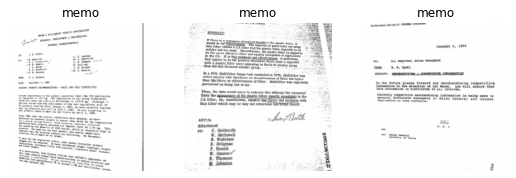

In [15]:
dls.show_batch(nrows=1, ncols=3)

In [16]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
learn.lr_find()

EOFError: 

In [ ]:
learn.fit_one_cycle(3, 1e-3)

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(6, lr_max=slice(1e-6, 1e-5))